In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab as plt
import blimpy
from blimpy import Waterfall
from blimpy import calcload
import os
import glob
import numpy as np
import time
from scipy.stats import norm, kurtosis, kurtosistest
import scipy
import numpy.ma as ma
import seaborn as sns

import sys
file_path = '/lustre/aoc/students/jsofair/playing-with-cosmic-data/filterbank/'
sys.path.insert(1, file_path[:54])
from analysis_functions import plot_tavg_power

In [12]:
file_list = glob.glob(os.path.join(file_path,'*.fil'))

ml_list = []
for i, file in enumerate(file_list):
    ml = blimpy.calcload.calc_max_load(os.path.join(file))
    ml_list.append(ml)
    print(f'{ml} -- {file[65:]}')

11.0 -- band_test_AC_CO-beam0001.fil
9.0 -- Band_Test_BD_C512-beam0001.fil
9.0 -- band_test_AC_C512-beam0001.fil
11.0 -- Band_Test_BD_C0-beam0001.fil
7.0 -- band_test_GPU3_BD_C32-beam0001.fil
11.0 -- band_test_AC_C32-beam0001.fil
4.0 -- band_test_AC_C544-beam0001.fil


In [13]:
t0=time.time()

water6 = Waterfall(os.path.normpath(file_list[6]), max_load = ml_list[6])


# water0 = Waterfall(os.path.normpath(file_list[0]), max_load = ml_list[0])
# water1 = Waterfall(os.path.normpath(file_list[1]), max_load = ml_list[1])
# water2 = Waterfall(os.path.normpath(file_list[2]), max_load = ml_list[2])
# water3 = Waterfall(os.path.normpath(file_list[3]), max_load = ml_list[3])
# water4 = Waterfall(os.path.normpath(file_list[4]), max_load = ml_list[4])
# water5 = Waterfall(os.path.normpath(file_list[5]), max_load = ml_list[5])
# water6 = Waterfall(os.path.normpath(file_list[6]), max_load = ml_list[6])

# water_list = [water0, water1, water2, water3, water4, water5, water6]
# print(water_list)

t1 = time.time()
print(f'Elapsed time: {t1 - t0}')

Elapsed time: 3.0622758865356445


In [14]:
water6.info()
# 640 channels
# ~4.2 M fine frequency channels


--- File Info ---
      machine_id :                                0
    telescope_id :                               -1
         src_raj :                 4:09:22.00873993
         src_dej :                12:17:39.84749624
        az_start :              6.927632722041e-310
        za_start :             4.6890767235416e-310
       data_type :                                1
            fch1 :           2540.4999961853027 MHz
            foff :           -7.62939453125e-06 MHz
          nchans :                          4194304
          nbeams :                                2
           ibeam :                                1
           nbits :                               32
   tstart (ISOT) :          2023-05-10T22:08:42.502
    tstart (MJD) :               60074.922714145854
           tsamp :                         0.131072
            nifs :                                1
     barycentric :                                1
   pulsarcentric :                           

In [155]:
def get_kurtosis(wf_in, n_divs=32):
    # This function grabs the kurtosis of each 1 MHz channel of a specified blimpy waterfall object\
    
    # wf_in: Specified blimpy waterfall object
    # n_divs: Number of divisions to break wf_in into
        # 32 is the correct number of channels to break a waterfall into assuming the frequency range
        # of the waterfall is 32 MHz
        
    np.set_printoptions(threshold=4)

    # Get power and frequency in increasing order
    if wf_in.header['foff'] < 0:
        pows_flipped = np.flip(wf_in.data)
        freqs_flipped = wf_in.get_freqs()[::-1]
    
    # Time-average the power
    pows_mean_flipped = np.mean(pows_flipped, axis=0)[0]    
    print(f'{np.shape(pows_mean_flipped)} {np.shape(freqs_flipped)}\n\n')
#     print(f'{(pows_mean_flipped)} {(freqs_flipped)}\n\n')


    # Split frequency and time-averaged power into n_divs channels
    freqs = np.array_split(freqs_flipped, n_divs)
    pows_mean = np.array_split(pows_mean_flipped, n_divs)
    
    print(np.shape(freqs), np.shape(pows_mean))
    kurts = []
    
#     divs = []
    
    for i, division in enumerate(pows_mean):
#         print(f'{i} {division}')
#         divs.append(division)
#         print(division)
#         print(kurtosis(division))
        kurts.append(kurtosis(division))

#     divs[0]

    print(pows_mean[0])
    
    
#     for i, division in enumerate(pows_mean):
# #         print(f'{i} {division}')
#         print(kurtosis(division))
#         kurts.append(kurtosis(division))
            
        
# #     bin_n = np.arange(start=1,stop=1025,step=1)
# #     print(bin_n)
        
    
    bins = []
    for chnl in freqs:
        bins.append(np.floor(chnl[0]))
    
    
#     print(np.shape(kurts), np.shape(freqs), np.shape(bins))
#     print((kurts))
#     freqs2 = np.array(freqs)
#     pows_mean2 = np.array(pows_mean)
    
#     print(f'Kurtosis here: {kurtosis(pows_mean[0])}')
    print(np.shape(bins))
    fig, ax = plt.subplots()
    
    ax.plot(bins,kurts,'.')
    
#     ax.plot(freqs,pows_mean)
    
#     ax.plot(freqs2.flatten(), pows_mean2.flatten())
    
#     ax.set_xlim(2508, 2541)
#     ax.set_ylim(np.amin(kurts)-1,np.amax(kurts))
    
#     ax.plot(bins, kurts)
#     plt.show()

(4194304,) (4194304,)


(512, 8192) (512, 8192)
[1.2437207e+09 1.2203743e+09 1.2283927e+09 ... 1.3285436e+09 1.3892742e+09
 1.3270838e+09]
(512,)


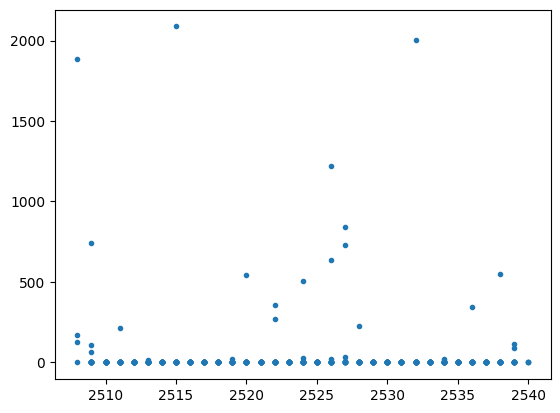

In [159]:
get_kurtosis(water6, 512)

In [141]:
plt.close('all')